https://www.kaggle.com/veb101/facial-expression-recognition-using-pytorch/notebook

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns
%matplotlib inline
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
from tqdm import tqdm

from torchsummary import summary

from PIL import Image
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import os, sys
os.chdir("/gdrive/My Drive/Colab Notebooks/PyTorch")
path='/gdrive/My Drive/Colab Notebooks/PyTorch'

In [4]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# dataset 불러오기

In [5]:
dataset = pd.read_csv(path+'/fer20131.csv')
dataset

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [6]:
dataset.Usage.value_counts() # 훈련, 검증용 데이터 수 확인 PublicTest가 테스트용

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

## Pixel column의 데이터를 pixel화 하기
48*48짜리로 바꿔야 함

In [7]:
trn_index=dataset.Usage=='Training'
vld_index=dataset.Usage=='PrivateTest'
tst_index=dataset.Usage=='PublicTest'


In [8]:
x = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    x.append(values)

x = np.array(x).reshape(-1,1,48,48)
x.shape


(35887, 1, 48, 48)

In [9]:
x_scaled=x/255
x_scaled

array([[[[0.2745098 , 0.31372549, 0.32156863, ..., 0.20392157,
          0.16862745, 0.16078431],
         [0.25490196, 0.23921569, 0.22745098, ..., 0.21960784,
          0.20392157, 0.17254902],
         [0.19607843, 0.16862745, 0.21176471, ..., 0.19215686,
          0.21960784, 0.18431373],
         ...,
         [0.35686275, 0.25490196, 0.16470588, ..., 0.28235294,
          0.21960784, 0.16862745],
         [0.30196078, 0.32156863, 0.30980392, ..., 0.41176471,
          0.2745098 , 0.18039216],
         [0.30196078, 0.28235294, 0.32941176, ..., 0.41568627,
          0.42745098, 0.32156863]]],


       [[[0.59215686, 0.58823529, 0.57647059, ..., 0.50588235,
          0.54901961, 0.47058824],
         [0.59215686, 0.58431373, 0.58431373, ..., 0.47843137,
          0.55294118, 0.5372549 ],
         [0.59215686, 0.59215686, 0.61176471, ..., 0.42745098,
          0.48235294, 0.57254902],
         ...,
         [0.7372549 , 0.7372549 , 0.4745098 , ..., 0.7254902 ,
          0.7254902 , 0

In [10]:
x_train=x_scaled[trn_index]
x_valid=x_scaled[vld_index]
x_test=x_scaled[tst_index]

x_train.shape, x_valid.shape, x_test.shape

((28709, 1, 48, 48), (3589, 1, 48, 48), (3589, 1, 48, 48))

In [11]:
y=np.array(dataset.emotion)
y_train=y[trn_index]
y_valid=y[vld_index]
y_test=y[tst_index]

y_train.shape, y_valid.shape, y_test.shape

((28709,), (3589,), (3589,))

In [12]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

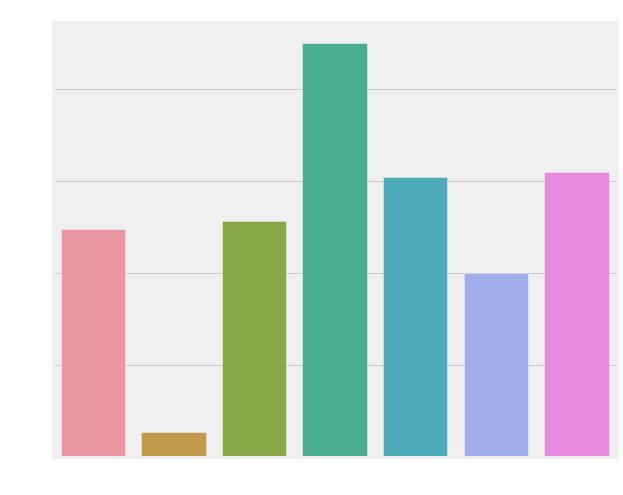

In [13]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution',fontsize=12,color='white')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)],color='white' )
_ = plt.xlabel('emotion',color='white')
_ = plt.ylabel('count',color='white')
_ = plt.yticks(color='white')

## Customized Dataset 만들기

In [14]:
emotions[6]

'Neutral'

In [15]:
from torch.utils.data import Dataset as Dataset

In [16]:
class Trainset(Dataset): 
  def __init__(self,transform=None):
    self.x_data = torch.from_numpy(x_train).double()
    self.y_data = torch.from_numpy(y_train)
    self.transform=transform
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.y_data[idx]
    if self.transform:
      x = self.transform(x)
    return x, y

In [17]:
class Validset(torch.utils.data.Dataset): 
  def __init__(self,transform=None):
    self.x_data = torch.from_numpy(x_valid).double()
    self.y_data = torch.from_numpy(y_valid)
    self.transform=transform
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.y_data[idx]
    if self.transform:
      x = self.transform(x)
    return x, y

In [18]:
class Testset(torch.utils.data.Dataset): 
  def __init__(self,transform=None):
    self.x_data = torch.from_numpy(x_test).double()
    self.y_data = torch.from_numpy(y_test)
    self.transform=transform
  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.y_data[idx]
    if self.transform:
      x = self.transform(x)
    return x, y

In [19]:
transform=transforms.Compose(
    [#transforms.ToTensor(),
     transforms.RandomHorizontalFlip()
     #transforms.Resize()
     ,transforms.Normalize([0.485], [0.229])])

In [20]:
trainset=Trainset(transform=transform)
validset=Validset(transform=transform)
testset=Testset(transform=transform)
dataset_sizes = {'train':len(trainset),'valid':len(validset),'test':len(testset)}

In [21]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=16,shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=16,shuffle=True)

In [22]:
dataloader={'train':trainloader,'valid':validloader}

## img 확인

torch.Size([16, 1, 48, 48])
tensor([6, 6, 3, 6, 6, 5, 6, 4, 3, 6, 4, 0, 3, 4, 2, 3])


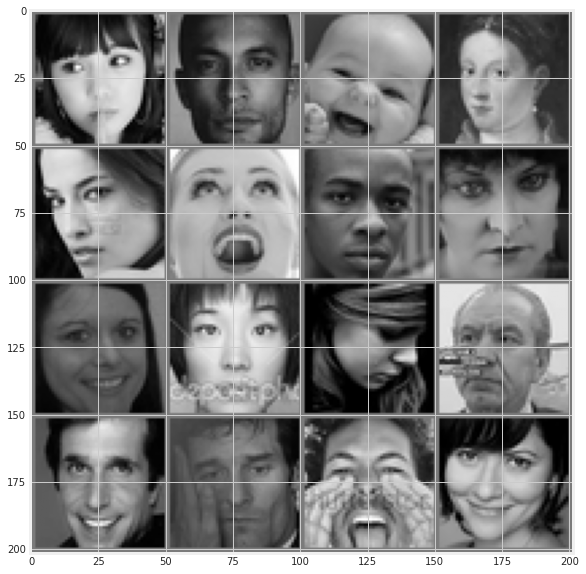

Neutral Neutral Happy Neutral Neutral Surprise Neutral   Sad Happy Neutral   Sad Angry Happy   Sad  Fear Happy


In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# get some random training images
dataiter = iter(trainloader) #iter는 원하는 값이 나올 때 까지 특정대상을 계속 돌림
images, labels = dataiter.next() #iter 다음에는 next로 부름
print(images.shape) # 16개 짜리 미니배치, 이미지 사이즈는 (1,48,48)
print(labels) # y가 숫자로 되어있고 그 숫자를 부르는 것임. 그래서label[j]가 필요

# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
#Make a grid of images.

#Args:
#    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)  
#        or a list of images all of the same size.

print(' '.join('%5s' % emotions[int(labels[j])] for j in range(16)))

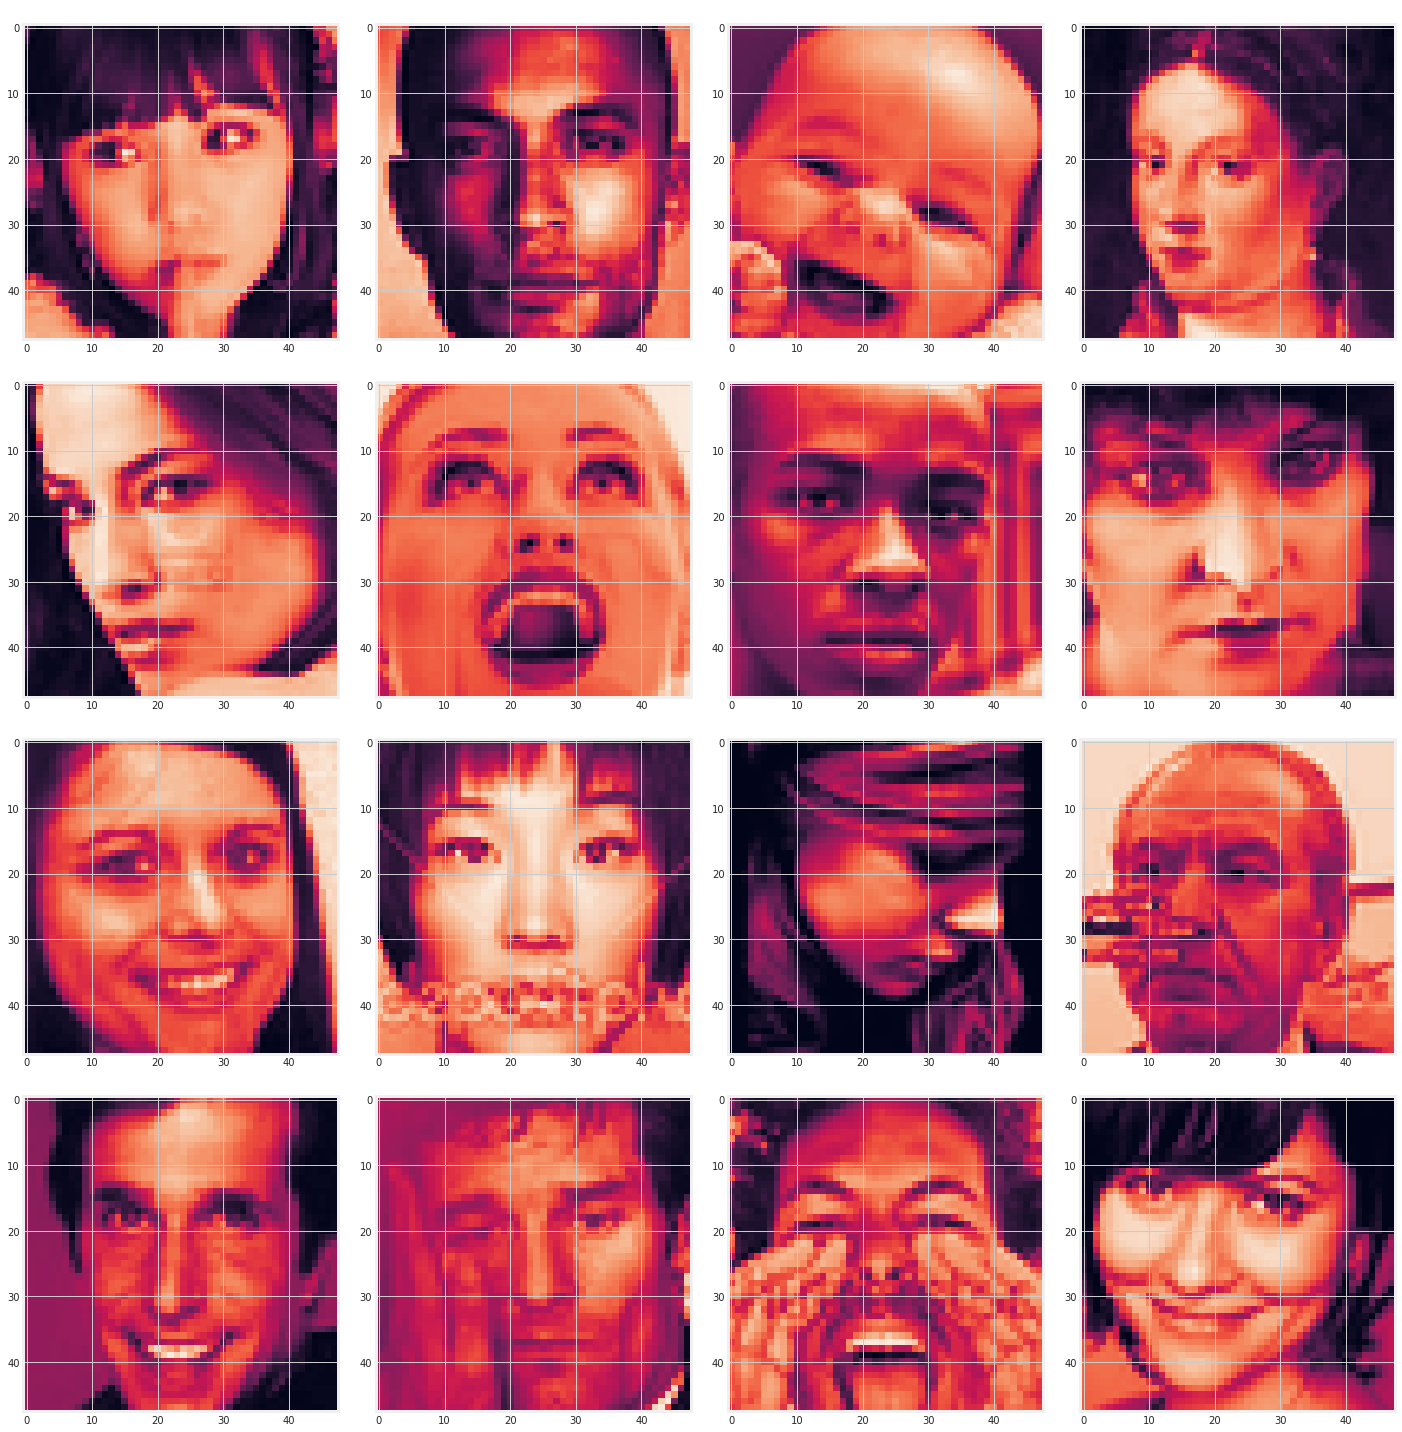

In [24]:
axes=[]
fig=plt.figure(figsize=(20,20))
rows=cols=4
for a in range(rows*cols):
    img = images[a].view(48,48)
    mean = torch.tensor([0.485])
    std = torch.tensor([0.229])
    img = std * img + mean
    axes.append( fig.add_subplot(rows, cols, a+1) )
    
    axes[-1].set_title(emotions[int(labels[a])],fontsize=15, color='white')  
    plt.imshow(img)
fig.tight_layout()    
plt.show()

# Modeling

## Model Training 함수

In [25]:
from torch.optim import lr_scheduler
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc=[]
    valid_acc=[]
    loss_list=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device,dtype=torch.double)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device=device, dtype=torch.double)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase =='train':
              scheduler.step(epoch_acc)

            if phase=='train':
              train_acc.append(epoch_acc)
            if phase == 'valid':
              valid_acc.append(epoch_acc)
              loss_list.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase=='valid':
              print(f'''last learning rate:{exp_lr_scheduler.state_dict()['_last_lr']}''')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc,valid_acc,loss_list

## 1) 일반 CNN

In [28]:
from collections import OrderedDict
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

      #(16,1,48,48)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        #(16,1,24,24)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        #(16,1,12,12)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        

        self.fc1=torch.nn.Sequential(OrderedDict([
            ('Linear',torch.nn.Linear(6* 6 * 128, 128, bias=True)),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False)),
            ('ReLU',torch.nn.ReLU())]))
        
        
        self.fc2=torch.nn.Sequential(OrderedDict([
            ('Linear',torch.nn.Linear(128, 128, bias=True)),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False)),
            ('ReLU',torch.nn.ReLU())]))
        
        self.result_layer=torch.nn.Linear(128, 7, bias=True)
         
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_normal(self.result_layer.weight)
        torch.nn.init.xavier_normal(self.fc1.Linear.weight)
        torch.nn.init.xavier_normal(self.fc2.Linear.weight)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1,6*6*128)    # 전결합층을 위해서 Flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.result_layer(out)

        return out



In [ ]:
model_ft = CNN().to(device,dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                  factor=0.1, patience=3, threshold=0.01, 
                                                  threshold_mode='rel', cooldown=0, min_lr=1e-9, 
                                                  eps=1e-09, verbose=False)
model_ft,train_acc,valid_acc,loss_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


Epoch 1/60
----------
train Loss: 1.8302 Acc: 0.2485
valid Loss: 1.7960 Acc: 0.2513
last learning rate:[0.001]

Epoch 2/60
----------
train Loss: 1.7930 Acc: 0.2541
valid Loss: 1.7593 Acc: 0.2686
last learning rate:[0.001]

Epoch 3/60
----------
train Loss: 1.7461 Acc: 0.2866
valid Loss: 1.6768 Acc: 0.3070
last learning rate:[0.001]

Epoch 4/60
----------
train Loss: 1.6660 Acc: 0.3362
valid Loss: 1.5716 Acc: 0.3865
last learning rate:[0.001]

Epoch 5/60
----------
train Loss: 1.5949 Acc: 0.3754
valid Loss: 1.4987 Acc: 0.4121
last learning rate:[0.001]

Epoch 6/60
----------
train Loss: 1.5407 Acc: 0.4022
valid Loss: 1.4533 Acc: 0.4366
last learning rate:[0.001]

Epoch 7/60
----------
train Loss: 1.4959 Acc: 0.4204
valid Loss: 1.4506 Acc: 0.4447
last learning rate:[0.001]

Epoch 8/60
----------
train Loss: 1.4452 Acc: 0.4421
valid Loss: 1.3645 Acc: 0.4781
last learning rate:[0.001]

Epoch 9/60
----------
train Loss: 1.4001 Acc: 0.4655
valid Loss: 1.3121 Acc: 0.4954
last learning rate:[

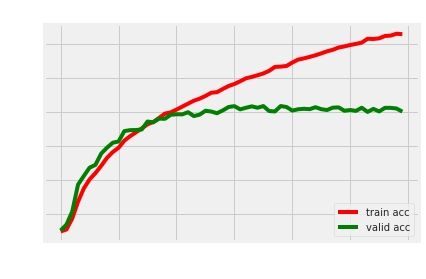

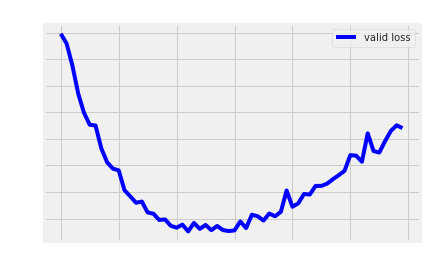

In [ ]:
plt.title('Accuracy',color='white')
plt.plot(train_acc, 'r', label='train acc')
plt.plot(valid_acc, 'g', label='valid acc')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend(loc='lower right')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

plt.title('Loss',color='white')
plt.plot(loss_list,'b',label='valid loss')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()


## 모델저장

In [ ]:
PATH='/gdrive/My Drive/Colab Notebooks/PyTorch/fer_CNN.pt'

In [ ]:
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
             }, PATH)

## 모델불러오기 및 학습 진행

In [31]:
model_ft = CNN().to(device,dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                  factor=0.1, patience=3, threshold=0.01, 
                                                  threshold_mode='rel', cooldown=0, min_lr=1e-9, 
                                                  eps=1e-09, verbose=False)
PATH='/gdrive/My Drive/Colab Notebooks/PyTorch/fer_CNN.pt'
checkpoint = torch.load(PATH)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
model_ft.train()

model_ft,train_acc,valid_acc,loss_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


Epoch 1/10
----------
train Loss: 1.8320 Acc: 0.2470
valid Loss: 1.7994 Acc: 0.2469
last learning rate:[0.001]

Epoch 2/10
----------
train Loss: 1.7958 Acc: 0.2532
valid Loss: 1.7634 Acc: 0.2575
last learning rate:[0.001]

Epoch 3/10
----------
train Loss: 1.7487 Acc: 0.2838
valid Loss: 1.7008 Acc: 0.3115
last learning rate:[0.001]

Epoch 4/10
----------
train Loss: 1.6785 Acc: 0.3311
valid Loss: 1.5889 Acc: 0.3826
last learning rate:[0.001]

Epoch 5/10
----------
train Loss: 1.6067 Acc: 0.3681
valid Loss: 1.5218 Acc: 0.4071
last learning rate:[0.001]

Epoch 6/10
----------
train Loss: 1.5555 Acc: 0.3979
valid Loss: 1.4763 Acc: 0.4313
last learning rate:[0.001]

Epoch 7/10
----------
train Loss: 1.5090 Acc: 0.4135
valid Loss: 1.4217 Acc: 0.4583
last learning rate:[0.001]

Epoch 8/10
----------
train Loss: 1.4662 Acc: 0.4374
valid Loss: 1.3815 Acc: 0.4731
last learning rate:[0.001]

Epoch 9/10
----------
train Loss: 1.4180 Acc: 0.4511
valid Loss: 1.3478 Acc: 0.4898
last learning rate:[

## 2) New CNN

In [26]:
from collections import OrderedDict
class NewCNN(torch.nn.Module):

    def __init__(self):
        super(NewCNN, self).__init__()

      #(16,1,48,48)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32))
            #torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        #(16,1,24,24)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64))
            #torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        #(16,1,12,12)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128))
            #torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.maxpool=torch.nn.MaxPool2d(kernel_size=2, stride=2)
        

        self.fc1=torch.nn.Sequential(OrderedDict([
            ('Linear1',torch.nn.Linear(6* 6 * 128, 128, bias=True)),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False)),
            ('ReLU',torch.nn.ReLU()),
            ('Linear2',torch.nn.Linear(128,7,bias=True))]))

         
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_normal(self.fc1.Linear1.weight)
        torch.nn.init.xavier_normal(self.fc1.Linear2.weight)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.maxpool(out)
        out = out.view(-1,6*6*128)    # 전결합층을 위해서 Flatten
        out = self.fc1(out)

        return out



In [ ]:
model_ft = NewCNN().to(device,dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                  factor=0.1, patience=3, threshold=0.01, 
                                                  threshold_mode='rel', cooldown=0, min_lr=1e-9, 
                                                  eps=1e-09, verbose=False)
model_ft,train_acc,valid_acc,loss_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


Epoch 1/60
----------
train Loss: 1.8016 Acc: 0.2632
valid Loss: 1.6809 Acc: 0.3307
last learning rate:[0.001]

Epoch 2/60
----------
train Loss: 1.7034 Acc: 0.3128
valid Loss: 1.6220 Acc: 0.3527
last learning rate:[0.001]

Epoch 3/60
----------
train Loss: 1.6366 Acc: 0.3549
valid Loss: 1.5382 Acc: 0.4051
last learning rate:[0.001]

Epoch 4/60
----------
train Loss: 1.5770 Acc: 0.3761
valid Loss: 1.4618 Acc: 0.4338
last learning rate:[0.001]

Epoch 5/60
----------
train Loss: 1.5165 Acc: 0.4023
valid Loss: 1.4080 Acc: 0.4586
last learning rate:[0.001]

Epoch 6/60
----------
train Loss: 1.4558 Acc: 0.4309
valid Loss: 1.3671 Acc: 0.4851
last learning rate:[0.001]

Epoch 7/60
----------
train Loss: 1.3970 Acc: 0.4591
valid Loss: 1.3206 Acc: 0.4837
last learning rate:[0.001]

Epoch 8/60
----------
train Loss: 1.3510 Acc: 0.4779
valid Loss: 1.2505 Acc: 0.5171
last learning rate:[0.001]

Epoch 9/60
----------
train Loss: 1.3143 Acc: 0.4979
valid Loss: 1.2551 Acc: 0.5261
last learning rate:[

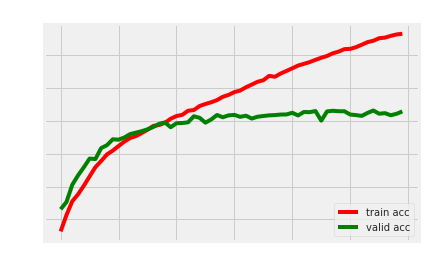

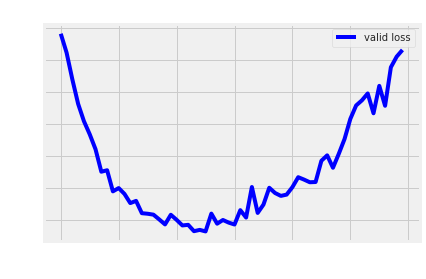

In [ ]:
plt.title('Accuracy',color='white')
plt.plot(train_acc, 'r', label='train acc')
plt.plot(valid_acc, 'g', label='valid acc')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend(loc='lower right')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

plt.title('Loss',color='white')
plt.plot(loss_list,'b',label='valid loss')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()


In [27]:
model_ft = NewCNN().to(device,dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                  factor=0.1, patience=3, threshold=0.01, 
                                                  threshold_mode='rel', cooldown=0, min_lr=1e-9, 
                                                  eps=1e-09, verbose=False)
model_ft,train_acc,valid_acc,loss_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


Epoch 1/30
----------
train Loss: 1.8287 Acc: 0.2491
valid Loss: 1.7431 Acc: 0.2909
last learning rate:[0.001]

Epoch 2/30
----------
train Loss: 1.7435 Acc: 0.2864
valid Loss: 1.6490 Acc: 0.3271
last learning rate:[0.001]

Epoch 3/30
----------
train Loss: 1.6888 Acc: 0.3227
valid Loss: 1.5823 Acc: 0.3764
last learning rate:[0.001]

Epoch 4/30
----------
train Loss: 1.6127 Acc: 0.3596
valid Loss: 1.4926 Acc: 0.4263
last learning rate:[0.001]

Epoch 5/30
----------
train Loss: 1.5457 Acc: 0.3930
valid Loss: 1.4739 Acc: 0.4358
last learning rate:[0.001]

Epoch 6/30
----------
train Loss: 1.4924 Acc: 0.4176
valid Loss: 1.4182 Acc: 0.4503
last learning rate:[0.001]

Epoch 7/30
----------
train Loss: 1.4518 Acc: 0.4370
valid Loss: 1.3515 Acc: 0.4851
last learning rate:[0.001]

Epoch 8/30
----------
train Loss: 1.4068 Acc: 0.4569
valid Loss: 1.3105 Acc: 0.5077
last learning rate:[0.001]

Epoch 9/30
----------
train Loss: 1.3616 Acc: 0.4765
valid Loss: 1.2631 Acc: 0.5124
last learning rate:[

In [28]:
optimizer_ft.state_dict()

{'param_groups': [{'dampening': 0,
   'lr': 0.001,
   'momentum': 0.9,
   'nesterov': False,
   'params': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27],
   'weight_decay': 0}],
 'state': {0: {'momentum_buffer': tensor([[[[ 1.8937e-01,  2.0659e-01,  1.7063e-01],
             [ 1.1508e-01,  1.9710e-01,  2.2606e-01],
             [ 7.9992e-02,  9.3633e-02,  1.5611e-01]]],
   
   
           [[[-2.5402e-02,  2.0545e-04, -1.0283e-02],
             [-4.9939e-02, -4.5533e-02, -6.5989e-02],
             [-4.4068e-02, -4.3547e-02, -7.5157e-02]]],
   
   
           [[[ 1.3524e-01,  1.4509e-01,  1.5168e-01],
             [ 1.1944e-01,  6.2386e-02,  1.2391e-01],
             [ 1.0022e-01,  4.8733e-02,  7.1388e-02]]],
   
   
           [[[ 2.5179e-01,  3.1342e-01,  3.2914e-01],
             [ 9.9448e-02,  1.5010e-01,  1.9476e-01],
   

## 모델저장

In [29]:
PATH='/gdrive/My Drive/Colab Notebooks/PyTorch/fer_NewCNN.pt'

In [30]:
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
             }, PATH)

## 모델불러오기 및 학습 진행

In [ ]:
model_ft = NewCNN().to(device,dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max',
                                                  factor=0.1, patience=3, threshold=0.01, 
                                                  threshold_mode='rel', cooldown=0, min_lr=1e-9, 
                                                  eps=1e-09, verbose=False)
PATH='/gdrive/My Drive/Colab Notebooks/PyTorch/fer_NewCNN.pt'
checkpoint = torch.load(PATH)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
model_ft.train()

model_ft,train_acc,valid_acc,loss_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

# VGG8

In [ ]:
from collections import OrderedDict
class VGG8(torch.nn.Module):

    def __init__(self):
        super(VGG8, self).__init__()

      #(16,1,48,48)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            #torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            #torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        #(16,1,24,24)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        #(16,1,12,12)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        

        self.fc1=torch.nn.Sequential(OrderedDict([
            ('Linear',torch.nn.Linear(6* 6 * 256, 256, bias=True)),
            ('ReLU',torch.nn.ReLU()),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False))]))
            
        
        
        self.fc2=torch.nn.Sequential(OrderedDict([
            ('Linear',torch.nn.Linear(256, 256, bias=True)),
            ('ReLU',torch.nn.ReLU()),
            ('Dropout',torch.nn.Dropout(0.5,inplace=False))]))
            
        self.result_layer=torch.nn.Linear(256, 7, bias=True)
         
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_normal(self.result_layer.weight)
        torch.nn.init.xavier_normal(self.fc1.Linear.weight)
        torch.nn.init.xavier_normal(self.fc2.Linear.weight)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1,6*6*256)    # 전결합층을 위해서 Flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.result_layer(out)

        return out



In [ ]:
model_ft_vgg8 = VGG8().to(device, dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_vgg8.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [ ]:
model_ft_vgg8 = train_model(model_ft_vgg8, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

Epoch 1/40
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.8111 Acc: 0.2411
last learning rate:[0.001]
valid Loss: 1.7611 Acc: 0.2742

Epoch 2/40
----------
train Loss: 1.7222 Acc: 0.3014
last learning rate:[0.001]
valid Loss: 1.6216 Acc: 0.3775

Epoch 3/40
----------
train Loss: 1.5938 Acc: 0.3775
last learning rate:[0.001]
valid Loss: 1.4896 Acc: 0.4271

Epoch 4/40
----------
train Loss: 1.5019 Acc: 0.4200
last learning rate:[0.001]
valid Loss: 1.4308 Acc: 0.4466

Epoch 5/40
----------
train Loss: 1.4269 Acc: 0.4521
last learning rate:[0.001]
valid Loss: 1.3385 Acc: 0.4901

Epoch 6/40
----------
train Loss: 1.3674 Acc: 0.4797
last learning rate:[0.001]
valid Loss: 1.3122 Acc: 0.4993

Epoch 7/40
----------
train Loss: 1.3132 Acc: 0.5006
last learning rate:[0.001]
valid Loss: 1.2566 Acc: 0.5127

Epoch 8/40
----------
train Loss: 1.2659 Acc: 0.5216
last learning rate:[0.001]
valid Loss: 1.1996 Acc: 0.5411

Epoch 9/40
----------
train Loss: 1.2214 Acc: 0.5393
last learning rate:[0.001]
valid Loss: 1.1763 Acc: 0.5472

Epoch 10/40
--

In [ ]:
model_ft_vgg8

(VGG8(
   (layer1): Sequential(
     (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer2): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer3): Sequential(
     (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc1): Sequential(
     (Linear): Linear(in_features=9216, out_features=256, bias=True)
     (ReLU): ReLU()
     (Dropout): Dropout(p=0.5, inplace=False)
   )
   (fc2): Seque

# ResNet9

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
              nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))
    
    return nn.Sequential(*layers)


class ResNet9(torch.nn.Module):
    def __init__(self):
        super(ResNet9,self).__init__()
        self.conv1 = conv_block(1, 16, pool=False) # 16 x 48 x 48
        self.conv2 = conv_block(16, 32, pool=True) # 32 x 24 x 24
        self.res1 = nn.Sequential( #  32 x 24 x 24
            conv_block(32, 32, pool=False), 
            conv_block(32, 32, pool=False)
        )

        self.conv3 = conv_block(32, 64, pool=True) # 64 x 12 x 12
        self.conv4 = conv_block(64, 128, pool=True) # 128 x 6 x 6

        self.res2 = nn.Sequential( # 128 x 6 x 6
             conv_block(128, 128), 
             conv_block(128, 128)
        )
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=2), # 128 x 3 x 3
            nn.Flatten(),
            nn.Linear(128*3*3, 512), #512
            nn.Linear(512, 7) # 7
        )
        self.network = nn.Sequential(
            self.conv1,
            self.conv2,
            self.res1,
            self.conv3,
            self.conv4,
            self.res2,
            self.classifier,
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out       

    def __repr__(self):
        return f"{self.network}"
    
    def __str__(self):
        summary(self.network, (1, 48, 48)) 

In [ ]:
model_ft_ResNet9 = ResNet9().to(device, dtype=torch.double)
criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_ResNet9.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft_ResNet9 = train_model(model_ft_ResNet9, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 1/30
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.5046 Acc: 0.4185
last learning rate:[0.001]
valid Loss: 1.3156 Acc: 0.4951

Epoch 2/30
----------
train Loss: 1.2593 Acc: 0.5179
last learning rate:[0.001]
valid Loss: 1.2398 Acc: 0.5174

Epoch 3/30
----------
train Loss: 1.1635 Acc: 0.5560
last learning rate:[0.001]
valid Loss: 1.1627 Acc: 0.5617

Epoch 4/30
----------
train Loss: 1.1012 Acc: 0.5846
last learning rate:[0.001]
valid Loss: 1.1661 Acc: 0.5598

Epoch 5/30
----------
train Loss: 1.0477 Acc: 0.6046
last learning rate:[0.001]
valid Loss: 1.0900 Acc: 0.5907

Epoch 6/30
----------
train Loss: 0.9975 Acc: 0.6271
last learning rate:[0.001]
valid Loss: 1.1703 Acc: 0.5776

Epoch 7/30
----------
train Loss: 0.9555 Acc: 0.6412
last learning rate:[0.001]
valid Loss: 1.0773 Acc: 0.6013

Epoch 8/30
----------
train Loss: 0.9140 Acc: 0.6581
last learning rate:[0.001]
valid Loss: 1.0767 Acc: 0.6077

Epoch 9/30
----------
train Loss: 0.8683 Acc: 0.6779
last learning rate:[0.001]
valid Loss: 1.0741 Acc: 0.5965

Epoch 10/30
--